In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchvision.transforms import functional as F
from scipy.ndimage import rotate
import time
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from tqdm.auto import tqdm
from torchvision.transforms import v2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import string

# Create a dictionary for mapping
mapping = {}

for i in range(26):
    mapping[i] = i # Map lowercase letter

for i in range(26,52):
    mapping[i]=i-26 # Map uppercase letter
turkish_letters = {52:26, 53:27, 54:27, 55:28, 56:28, 57:29, 58:30, 59:30, 60:31, 61:31}
mapping.update(turkish_letters)
print(mapping)


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 0, 27: 1, 28: 2, 29: 3, 30: 4, 31: 5, 32: 6, 33: 7, 34: 8, 35: 9, 36: 10, 37: 11, 38: 12, 39: 13, 40: 14, 41: 15, 42: 16, 43: 17, 44: 18, 45: 19, 46: 20, 47: 21, 48: 22, 49: 23, 50: 24, 51: 25, 52: 26, 53: 27, 54: 27, 55: 28, 56: 28, 57: 29, 58: 30, 59: 30, 60: 31, 61: 31}


In [5]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset
class CSVDataset(Dataset):
    def __init__(self, csv_file, mapping):
        # Load the data
        self.data = pd.read_csv(csv_file)
        # Store the mapping
        self.mapping = mapping

    def __getitem__(self, index):
        # Get the data for one example
        example_data = self.data.iloc[index]
        # Separate the features from the target
        features = torch.tensor(example_data[2:].values, dtype=torch.float32).reshape(1, 28, 28)
        target = torch.tensor(self.mapping[example_data.iloc[1]], dtype=torch.long)
        return features, target

    def __len__(self):
        return len(self.data)

    def classes(self, index):
        return self.mapping[self.data.iloc[index].iloc[1]]

# Create instances of the dataset
train_data = CSVDataset('final_dataset/train_dataset.csv', mapping)
test_data = CSVDataset('final_dataset/test_dataset.csv', mapping)

In [6]:
image, label = train_data[1134]
label.item(), image.shape

(9, torch.Size([1, 28, 28]))

In [7]:
classes_list = set()
for i in range(len(test_data)):
    _, target = test_data[i]
    classes_list.add(target.item())

In [8]:
classes_list

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31}

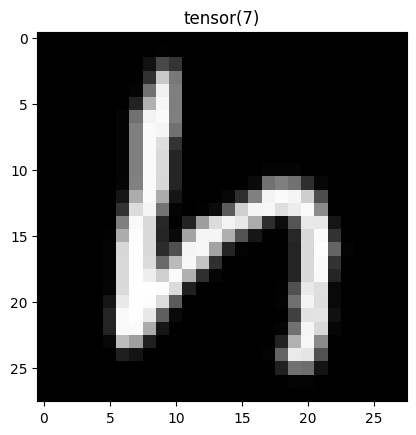

In [9]:
number = random.randint(0,len(train_data))
image, label = train_data[number]
classes_list
plt.title(label)
plt.imshow(image.squeeze(), cmap="gray")

In [10]:
BATCH_SIZE = 32


train_dataloader = DataLoader(train_data, #Dataset to iterate on for the according batch size.
                              batch_size = BATCH_SIZE, #Size of every single iteration.
                              shuffle = True, #To make the loaded data selected randomly.
                              )
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"For training data there is {len(train_dataloader)} iterations with the batch size of {BATCH_SIZE}.")
print(f"For testing data there is {len(test_dataloader)} iterations with the batch size of {BATCH_SIZE}.")

For training data there is 11529 iterations with the batch size of 32.
For testing data there is 1951 iterations with the batch size of 32.


In [11]:
import torch
from torch import nn
import torch.nn.functional as F

class LetterRecognizerModel2(nn.Module):
    def __init__(self):
        super().__init__()

        ### ------------ feature map layers --------------- ###

        # first convolution error
        self.conv1 = nn.Conv2d(1, 3, 5, padding = 2)
        self.conv2 = nn.Conv2d(3, 6, 3, padding = 1)
        self.bnorm1 = nn.BatchNorm2d(6)
        # output size: (28 + 2*1 - 3)/1 + 2 = 28 /2 # max pool = 14

        self.conv3 = nn.Conv2d(6, 12, 3, padding = 1)
        self.conv4 = nn.Conv2d(12, 24, 3, padding = 1)
        self.bnorm2 = nn.BatchNorm2d(24)
        # output size: (14 + 2*1 - 3)/1 + 2 = 14 /2 # Pooling = 7

        ### ------------ Linear decision layers --------------###
        self.fc1 = nn.Linear(7*7*24, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, len(classes_list))

    def forward(self, x):

        # first block
        x = F.max_pool2d(self.conv2(self.conv1(x)),2)
        x = F.leaky_relu(self.bnorm1(x))


        x = F.max_pool2d(self.conv4(self.conv3(x)), 2)
        x = F.leaky_relu(self.bnorm2(x))

        # reshape for linear layer
        nUnits = x.shape.numel()/x.shape[0]
        x = x.view(-1, int(nUnits))

        # linear layers
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p = .5, training = self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p = .5, training = self.training)
        x = self.fc3(x)


        return x

torch.manual_seed(42)

model_2 = LetterRecognizerModel2().to(device)

model_2


LetterRecognizerModel2(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                             lr=0.001,
                             weight_decay=0.1)

In [13]:
def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [14]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
# Imported from learnpytorch.io directly...

In [15]:
def train_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  train_loss, train_acc = 0 , 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device) , y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_func(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss is:{train_loss:.5f}, Train accuracy is:{train_acc:.2f}%")
  return train_loss, train_acc

def test_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_func(y_true=y,
                                y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss is:{test_loss:.6f}, Test accuracy is:{test_acc:.6f}%")
  return test_loss, test_acc

In [ ]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train and test model
epochs = 50
for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_part(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_func=accuracy_func,
        device=device)
    test_loss, test_acc = test_part(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer = optimizer,
        accuracy_func=accuracy_func,
        device=device)
    train_losses.append(train_loss.detach().cpu().numpy())
    train_accuracies.append(train_acc)
    test_losses.append(test_loss.detach().cpu().numpy())
    test_accuracies.append(test_acc)


    print(f"Epoch: {epoch}\n---------")

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Train loss is:2.89129, Train accuracy is:19.37%
Test loss is:2.574373, Test accuracy is:28.251217%
Epoch: 0
---------
Train loss is:0.74587, Train accuracy is:77.30%
Test loss is:0.516240, Test accuracy is:84.238852%
Epoch: 1
---------
Train loss is:0.43061, Train accuracy is:87.30%
Test loss is:0.523252, Test accuracy is:84.863532%
Epoch: 2
---------
Train loss is:0.40814, Train accuracy is:88.09%
Test loss is:0.502218, Test accuracy is:85.456176%
Epoch: 3
---------
Train loss is:0.39733, Train accuracy is:88.43%
Test loss is:0.445834, Test accuracy is:87.439134%
Epoch: 4
---------
Train loss is:0.39232, Train accuracy is:88.55%
Test loss is:9.659653, Test accuracy is:16.452140%
Epoch: 5
---------
Train loss is:0.39244, Train accuracy is:88.60%
Test loss is:0.462757, Test accuracy is:86.696246%
Epoch: 6
---------
Train loss is:0.38741, Train accuracy is:88.73%
Test loss is:0.484691, Test accuracy is:86.246797%
Epoch: 7
---------
Train loss is:0.38691, Train accuracy is:88.74%
Test los